In [2]:
from typing import List, Tuple, Union
import os

import scanpy as sc
import anndata as ad

import torch
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class SingleCellDataset(Dataset):
    """ Single cell dataset.
        root: root directory of dataset
        transform: transform applied to each data object
        pre_transform: transform applied to the whole dataset
        pre_filter: filter applied to the whole dataset
    """
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.filenames = []
        self.processed_file_names = []
        # get all filenames
        for filename in os.listdir(root):
            if filename.endswith('.h5ad'):
                self.filenames.append(filename)
        # process all files
        self.process()        
    
    @property
    def raw_file_names(self):
        return self.filenames
    
    @property
    def processed_file_names(self):
        return self.processed_file_names

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            # Read rna object from 'raw_path'
            rna = sc.read_h5ad(raw_path)

            if self.pre_filter is not None and not self.pre_filter(rna):
                continue

            if self.pre_transform is not None:
                rna = self.pre_transform(rna)

    # pre_transform: transform applied to the whole dataset
    def pre_transform(self, adata):
        # filter out genes with zero expression
        sc.pp.filter_genes(adata, min_counts=1)
        # log transform
        sc.pp.log1p(adata)
        # scale
        sc.pp.scale(adata)
        return adata

In [5]:
import torch
from torch_geometric.data import Data

data = Data(x=torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float), 
            edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long))

data.train_idx = torch.tensor([0, 1], dtype=torch.long)
data.test_mask = torch.tensor([False, True, False], dtype=torch.bool)

print(f"The number of cells: {data.num_nodes}")
print(f"The number of genes: {data.num_features}")

print(f"Is the graph directed: {data.is_directed()}")
print(f"Is the graph undirected: {data.is_undirected()}")

# pytorch tensor functionality
print(f"Shape of x: {data.x.shape}")

data = data.pin_memory()
data = data.to('cuda:0', non_blocking=True)

The number of cells: 3
The number of genes: 2
Is the graph directed: False
Is the graph undirected: True
Shape of x: torch.Size([3, 2])


# Load dataset

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Spatial CITE-seq mouse spleen dataset
RNA_data_path = "/home/wuxinchao/data/st_cite_data/spatial_cite_data/GSM6578058_mousespleen_RNA.tsv.gz"
Prot_data_path = "/home/wuxinchao/data/st_cite_data/spatial_cite_data/GSM6578067_mousespleen_protein.tsv.gz"

rna = sc.read_csv(RNA_data_path, delimiter='\t', first_column_names=True)
prot = sc.read_csv(Prot_data_path, delimiter='\t', first_column_names=True)

In [5]:
# define the coordinates of each cell

rna.obs["coord"] = rna.obs.index
rna.obs["X_coord"] = rna.obs["coord"].apply(lambda x: x.split("x")[0])
rna.obs["Y_coord"] = rna.obs["coord"].apply(lambda x: x.split("x")[1])

prot.obs["coord"] = prot.obs.index
prot.obs["X_coord"] = prot.obs["coord"].apply(lambda x: x.split("x")[0])
prot.obs["Y_coord"] = prot.obs["coord"].apply(lambda x: x.split("x")[1])

In [9]:
# define the neighbor cells of each cell, which means within the distance of 1
# distance = |X_1 - X_2| + |Y_1 - Y_2|
adj_mtx = np.zeros((rna.shape[0], rna.shape[0]))
for i in range(rna.shape[0]):
    for j in range(rna.shape[0]):
        if abs(int(rna.obs["X_coord"][i]) - int(rna.obs["X_coord"][j])) + abs(int(rna.obs["Y_coord"][i]) - int(rna.obs["Y_coord"][j])) <= 1:
            adj_mtx[i, j] = 1

adj_mtx

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
# convert adj_mtx to edge_index
edge_index = []
for i in range(adj_mtx.shape[0]):
    for j in range(adj_mtx.shape[1]):
        if adj_mtx[i, j] == 1:
            edge_index.append([i, j])

In [16]:
prot.obs_names 

Index(['22x41', '35x38', '27x5', '32x16', '17x7', '13x37', '36x15', '36x42',
       '31x27', '10x16',
       ...
       '22x8', '10x30', '25x35', '35x18', '21x44', '39x14', '31x44', '32x20',
       '32x11', '29x25'],
      dtype='object', length=1303)

In [17]:
rna.obs_names

Index(['15x39', '37x34', '37x26', '19x15', '36x20', '25x12', '21x30', '20x16',
       '23x15', '13x35',
       ...
       '14x35', '14x20', '14x13', '14x18', '14x15', '14x14', '14x42', '14x32',
       '14x11', '23x3'],
      dtype='object', length=1303)

In [4]:
B01825A4 = sc.read_csv("/home/wuxinchao/data/project/spatial-CITE-seq/mid_result/B01825A4_rna_prot_concat.csv", first_column_names=True)
B01825A4

AnnData object with n_obs × n_vars = 8628 × 25828

In [8]:
B01825A4.obs_names

Index(['37_3', '23_65', '78_72', '94_32', '42_4', '103_77', '17_29', '15_4',
       '106_43', '5_35',
       ...
       '113_65', '92_70', '113_64', '113_73', '113_61', '113_62', '113_70',
       '113_69', '112_78', '113_75'],
      dtype='object', length=8628)

In [9]:
# define the neighbors of each cell
B01825A4.obs["coord"] = B01825A4.obs.index
B01825A4.obs["X_coord"] = B01825A4.obs["coord"].apply(lambda x: x.split("_")[0])
B01825A4.obs["Y_coord"] = B01825A4.obs["coord"].apply(lambda x: x.split("_")[1])

# define the neighbor cells of each cell, which means within the distance of 1
# distance = |X_1 - X_2| + |Y_1 - Y_2|
adj_mtx = np.zeros((B01825A4.shape[0], B01825A4.shape[0]))
for i in range(B01825A4.shape[0]):
    for j in range(B01825A4.shape[0]):
        if abs(int(B01825A4.obs["X_coord"][i]) - int(B01825A4.obs["X_coord"][j])) + abs(int(B01825A4.obs["Y_coord"][i]) - int(B01825A4.obs["Y_coord"][j])) <= 1:
            adj_mtx[i, j] = 1

# convert the adj_mtx to edge_index
edge_index = []
for i in range(adj_mtx.shape[0]):
    for j in range(adj_mtx.shape[1]):
        if adj_mtx[i, j] == 1 and i != j:
            edge_index.append([i, j])

In [12]:
B01825A4.X[:,0].shape

(8628,)

In [11]:
# get the dim of RNA and prot
B01825A4.X.shape, B01825A4.var_names.str.endswith("prot").sum()

((8628, 25828), 11)

In [13]:
B01825A4[:, ~B01825A4.var_names.str.endswith("prot")]

View of AnnData object with n_obs × n_vars = 8628 × 25817
    obs: 'coord', 'X_coord', 'Y_coord'

In [22]:
rna = B01825A4[:, ~B01825A4.var_names.str.endswith("prot")]
prot = B01825A4[:, B01825A4.var_names.str.endswith("prot")]
rna, prot

(View of AnnData object with n_obs × n_vars = 8628 × 25817
     obs: 'coord', 'X_coord', 'Y_coord',
 View of AnnData object with n_obs × n_vars = 8628 × 11
     obs: 'coord', 'X_coord', 'Y_coord')

# RNA preprocess

In [32]:
# qc metrics
rna.obs["n_genes_by_counts"] = np.count_nonzero(rna.X, axis=1)
rna.obs["total_counts"] = rna.X.sum(axis=1)

/tmp/ipykernel_3082663/2508096313.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs["n_genes_by_counts"] = np.count_nonzero(rna.X, axis=1)


/tmp/ipykernel_3082663/3308291691.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rna.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_3082663/3308291691.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rna.obs["total_counts"][rna.obs["total_counts"] < 4000], kde=False, bins=40, 

<AxesSubplot: xlabel='n_genes_by_counts'>

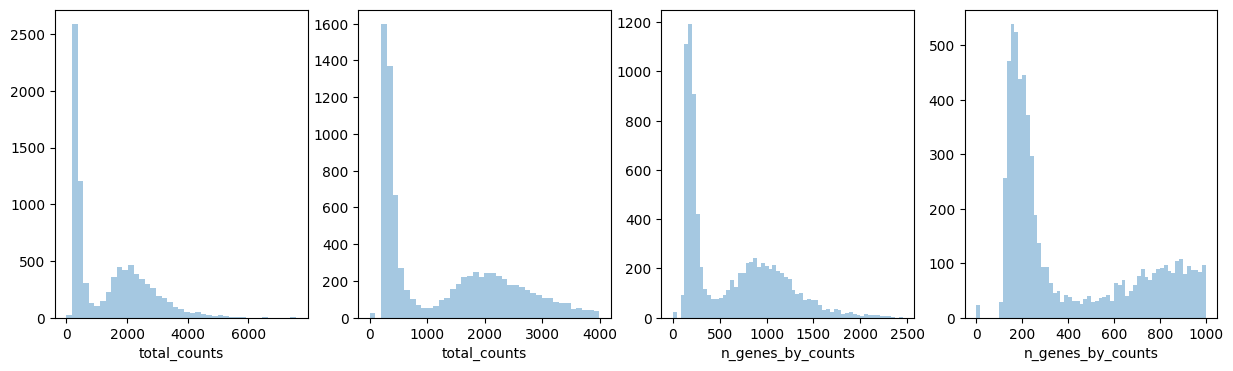

In [41]:
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(rna.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(rna.obs["total_counts"][rna.obs["total_counts"] < 4000], kde=False, bins=40, ax=axs[1])
sns.distplot(rna.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(rna.obs["n_genes_by_counts"][rna.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [42]:
sc.pp.filter_cells(rna, min_counts=800)
sc.pp.filter_cells(rna, max_counts=5000)
sc.pp.filter_genes(rna, min_cells=10)

In [43]:
sc.pp.normalize_total(rna, inplace=True)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, flavor="seurat", n_top_genes=2000)

In [45]:
sc.pp.pca(rna)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="clusters")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


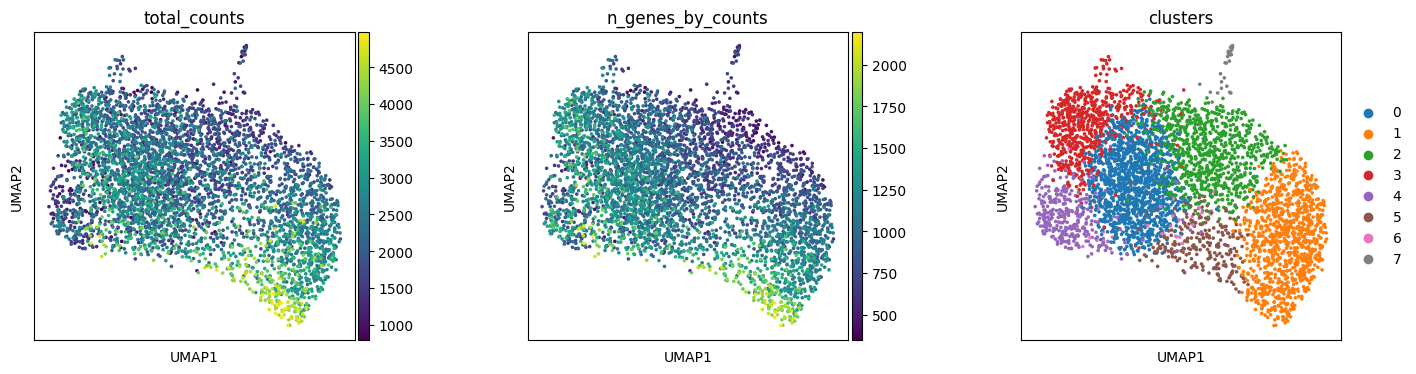

In [46]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(rna, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [56]:
rna.obs["X_coord"] = rna.obs["X_coord"].astype(int)
rna.obs["Y_coord"] = rna.obs["Y_coord"].astype(int)
rna.obsm["X_spatial"] = rna.obs[["X_coord", "Y_coord"]].values

In [121]:
# rna.obsm = rna.obs[["X_coord", "Y_coord"]].values
rna.obsm["X_spatial"]

ArrayView([[ 94,  32],
           [103,  77],
           [ 17,  29],
           ...,
           [ 23,  59],
           [ 82,  67],
           [ 73,  25]])

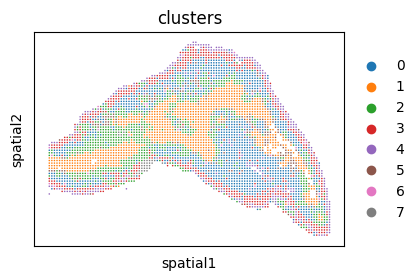

In [59]:
sc.pl.spatial(rna, color="clusters", spot_size=0.6)

In [117]:
rna.obsm["X_spatial"]

ArrayView([[ 94,  32],
           [103,  77],
           [ 17,  29],
           ...,
           [ 23,  59],
           [ 82,  67],
           [ 73,  25]])

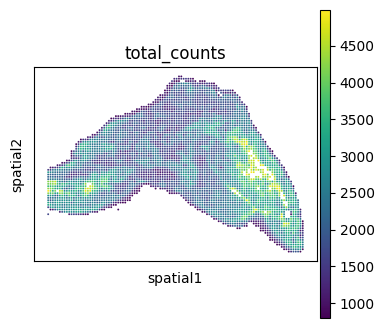

In [116]:
sc.pl.spatial(rna, color="total_counts", spot_size=0.8)

In [60]:
rna.obsm["X_spatial"].max(axis=0), rna.obsm["X_spatial"].min(axis=0)

(array([109,  77]), array([0, 2]))

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


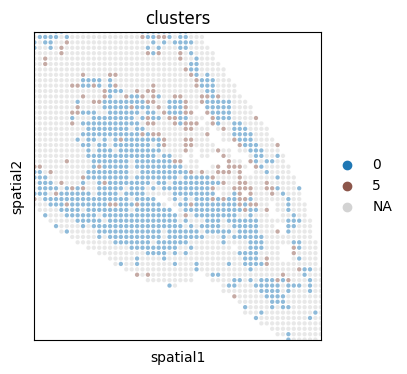

In [64]:
sc.pl.spatial(rna, color="clusters", groups=["0", "5"], crop_coord=[56,109,20,77], alpha=0.5, spot_size=0.8)

categories: 0, 1, 2, etc.
var_group_labels: 5


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


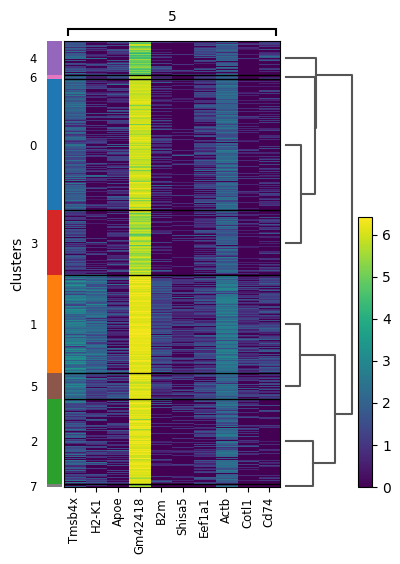

In [65]:
sc.tl.rank_genes_groups(rna, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(rna, groups="5", n_genes=10, groupby="clusters")

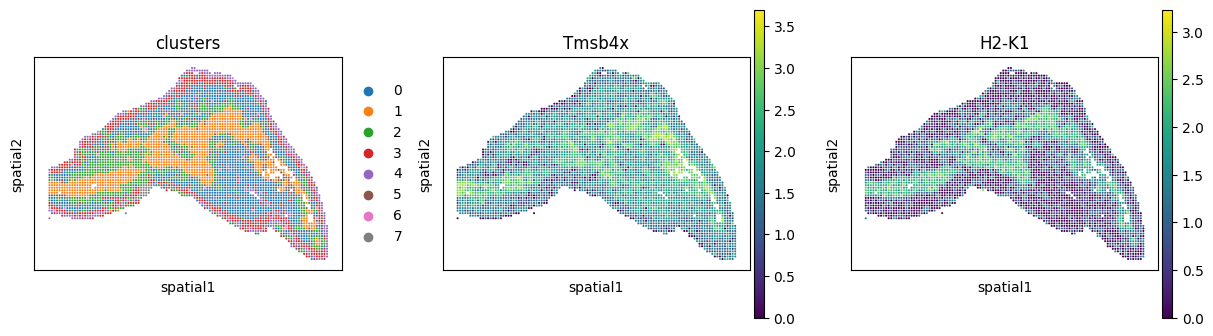

In [66]:
sc.pl.spatial(rna, color=["clusters", "Tmsb4x", "H2-K1"], spot_size=0.8)

In [74]:
rna.uns["rank_genes_groups"]["names"]

rec.array([('Rag1', 'H2-K1', 'Cdh12', 'Themis', 'Filip1l', 'Tmsb4x', 'Igkc', 'Ushbp1'),
           ('Trbc2', 'Rplp1', 'Hexb', 'Arpp21', 'Gm26870', 'H2-K1', 'Ighm', 'Gm28897'),
           ('Tcf7', 'Cdk8', 'Cdk8', 'Tcf12', 'Gsn', 'Apoe', 'Jchain', 'Gm49171'),
           ...,
           ('Pdlim7', 'Themis', 'Tmsb4x', 'H2-K1', 'Hexb', 'Themis', 'Crkl', 'Ndufa4'),
           ('H2-K1', '1110046J04Rik', 'Cd74', 'Rplp1', 'Cdk8', 'Trim2', 'Arhgap9', 'Ppp1ca'),
           ('Camk1d', 'Rag1', 'Fth1', 'Cdk8', 'Gm42418', 'Hbb-bs', 'Fscn1', 'Prdx1')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

# Protein preprocess

In [76]:
from muon import prot as pt

In [78]:
pt.pp.clr(prot)

In [79]:
prot.obs["X_coord"] = prot.obs["X_coord"].astype(int)
prot.obs["Y_coord"] = prot.obs["Y_coord"].astype(int)
prot.obsm["X_spatial"] = prot.obs[["X_coord", "Y_coord"]].values

/tmp/ipykernel_3082663/1805306776.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prot.obs["X_coord"] = prot.obs["X_coord"].astype(int)


In [83]:
prot = prot[rna.obs_names, :]

In [84]:
prot, rna

(View of AnnData object with n_obs × n_vars = 4395 × 11
     obs: 'coord', 'X_coord', 'Y_coord'
     obsm: 'X_spatial',
 AnnData object with n_obs × n_vars = 4395 × 16182
     obs: 'coord', 'X_coord', 'Y_coord', 'n_genes_by_counts', 'total_counts', 'n_counts', 'clusters'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors', 'rank_genes_groups', 'dendrogram_clusters'
     obsm: 'X_pca', 'X_umap', 'X_spatial'
     varm: 'PCs'
     obsp: 'distances', 'connectivities')

In [85]:
# select the highly variable genes
rna = rna[:, rna.var["highly_variable"]]

# RNA-Protein integration

In [87]:
adj_mtx = np.zeros((rna.shape[0], rna.shape[0]))
for i in range(rna.shape[0]):
    for j in range(rna.shape[0]):
        if abs(int(rna.obs["X_coord"][i]) - int(rna.obs["X_coord"][j])) + abs(int(rna.obs["Y_coord"][i]) - int(rna.obs["Y_coord"][j])) <= 1:
            adj_mtx[i, j] = 1

# convert the adj_mtx to edge_index
edge_index = []
for i in range(adj_mtx.shape[0]):
    for j in range(adj_mtx.shape[1]):
        if adj_mtx[i, j] == 1 and i != j:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t()

Firstly, let's set the problem as a simple integration of RNA and protein data. The obejct is to make the RNA and protein data to get the same hidden dim which is corresponding to the same biological meaning. And the Y will be given as the cluster label of the RNA clustering result. The RNA and protein data will be integrated by the following steps:
1. RNA and protein data will be encoded by different encoder, which is a simple MLP with 2 hidden layers.
2. The encoded RNA and protein data will be fused by cross-attention mechanism. The attention weight will be calculated by the dot product of the encoded RNA and protein data.

In [110]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader

# concat rna and protein count
x = torch.tensor(np.concatenate([rna.X, prot.X], axis=1), dtype=torch.float)
y = rna.obs["clusters"].astype(int).values
data = Data(x=x, y=torch.tensor(y).contiguous(), edge_index=edge_index)

# loader = NeighborLoader(
#     data,
#     num_neighbors=1,
#     batch_size=64,
#     shuffle=True,
# )

In [113]:
from torch_geometric.nn import GATConv, Linear

class GraRPINet(torch.nn.Module):
    def __init__(self, input_dim_rna, input_dim_prot, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.rna_embedding = Linear(input_dim_rna, hidden_channels)
        self.prot_embedding = Linear(input_dim_prot, hidden_channels)
        self.conv1 = GATConv((-1, -1), hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels * heads)
        self.conv2 = GATConv((-1, -1), out_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels * heads)

    def forward(self, x, edge_index, input_dim_rna):
        x_rna = self.rna_embedding(x[:, :input_dim_rna])
        x_prot = self.prot_embedding(x[:, input_dim_rna:])
        x = torch.cat([x_rna, x_prot], dim=1)
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x
    
model = GraRPINet(hidden_channels=32, out_channels=8, input_dim_rna=rna.shape[1], input_dim_prot=prot.shape[1])
model

GraRPINet(
  (rna_embedding): Linear(2000, 32, bias=True)
  (prot_embedding): Linear(11, 32, bias=True)
  (conv1): GATConv((-1, -1), 32, heads=4)
  (lin1): Linear(-1, 128, bias=True)
  (conv2): GATConv((-1, -1), 8, heads=4)
  (lin2): Linear(-1, 32, bias=True)
)

In [114]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
def train(epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        loss = train_step()
        losses.append(loss)
        print(f"Epoch {epoch + 1}/{epochs} loss: {loss:.5f}")
    return losses

def train_step():
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, input_dim_rna=rna.shape[1])
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

train_loss_history = train()

Epoch 1/100 loss: 4.60729
Epoch 2/100 loss: 2.39525
Epoch 3/100 loss: 2.37668
Epoch 4/100 loss: 3.50960
Epoch 5/100 loss: 2.69970
Epoch 6/100 loss: 1.53925
Epoch 7/100 loss: 1.57262
Epoch 8/100 loss: 1.42409
Epoch 9/100 loss: 1.26159
Epoch 10/100 loss: 1.14796
Epoch 11/100 loss: 1.17841
Epoch 12/100 loss: 1.04847
Epoch 13/100 loss: 0.97112
Epoch 14/100 loss: 0.95262
Epoch 15/100 loss: 0.90784
Epoch 16/100 loss: 0.84091
Epoch 17/100 loss: 0.85725
Epoch 18/100 loss: 0.81100
Epoch 19/100 loss: 0.78206
Epoch 20/100 loss: 0.76748
Epoch 21/100 loss: 0.73347
Epoch 22/100 loss: 0.69486
Epoch 23/100 loss: 0.69631
Epoch 24/100 loss: 0.66626
Epoch 25/100 loss: 0.63392
Epoch 26/100 loss: 0.62376
Epoch 27/100 loss: 0.60915
Epoch 28/100 loss: 0.56574
Epoch 29/100 loss: 0.54652
Epoch 30/100 loss: 0.53325
Epoch 31/100 loss: 0.49642
Epoch 32/100 loss: 0.47464
Epoch 33/100 loss: 0.47086
Epoch 34/100 loss: 0.44194
Epoch 35/100 loss: 0.42222
Epoch 36/100 loss: 0.41018
Epoch 37/100 loss: 0.38981
Epoch 38/1

# RNA Protein integration through cross-attention

In [ ]:
# set the rna_embedding as query, prot_embedding as key 
# and value for cross attention
# the output of the cross attention is the new embedding

from torch_geometric.nn import GATConv, Linear

class GraphCrossAttn(torch.nn.Module):
    def __init__(self, rna_input_dim, prot_input_dim, hidden_dim, embedding_dim, heads=4):
        super().__init__()
        self.rna_input_dim = rna_input_dim
        self.prot_input_dim = prot_input_dim
        # encoding
        self.rna_embedding = Linear(rna_input_dim, embedding_dim)
        self.prot_embedding = Linear(prot_input_dim, embedding_dim)
        self.cross_attn1 = GATConv((-1, -1), hidden_dim, heads=heads, dropout=0.2, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_dim * heads)
        self.cross_attn2 = GATConv((-1, -1), hidden_dim, heads=heads, dropout=0.2, add_self_loops=False)
        self.lin2 = Linear(-1, hidden_dim * heads)
        # aggregating the cross attention heads
        self.cross_attn_agg = Linear(-1, hidden_dim)
        # decoding
        self.rna_decoding = Linear(hidden_dim, embedding_dim)
        self.prot_decoding = Linear(hidden_dim, embedding_dim)
        self.rna_recon = Linear(embedding_dim, rna_input_dim)
        self.prot_recon = Linear(embedding_dim, prot_input_dim)
        
    def forward(self, data):
        rna_embedding = self.rna_embedding(data.x[:, :self.rna_input_dim])
        prot_embedding = self.prot_embedding(data.x[:, self.rna_input_dim:])
        x = torch.cat([rna_embedding, prot_embedding], dim=1)
        x = self.cross_attn1(x, data.edge_index) + self.lin1(x)
        x = x.relu()
        x = self.cross_attn2(x, data.edge_index) + self.lin2(x)
        x = x.relu()
        x = self.cross_attn_agg(x)
        embedding = x.relu()
        rna_embedding = self.rna_decoding(embedding)
        prot_embedding = self.prot_decoding(embedding)
        rna_recon = self.rna_recon(rna_embedding)
        prot_recon = self.prot_recon(prot_embedding)
        return rna_recon, prot_recon, embedding

In [ ]:
def masked_value_loss(pred, target):
    mask = target != 0
    loss = F.mse_loss(pred[mask], target[mask])
    return loss

# get the train dataset and validation dataset

In [1]:
import scanpy as sc
import muon as mu

# 10X 10k PBMC dataset
pbmc10k_datafile = "/home/wuxinchao/data/project/spatial-CITE-seq/mid_result/pbmc10k_totalseqB.h5mu"
pbmc10k = mu.read_h5mu(pbmc10k_datafile)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rna = pbmc10k.mod['rna']
prot = pbmc10k.mod['prot']

In [3]:
import torch
import numpy as np
from torch_geometric.data import Data

concat_data = np.concatenate([rna.X.A, prot.X.A], axis=1)

adj_mtx = rna.obsp['connectivities'].toarray()
edge_index = []
for i in range(adj_mtx.shape[0]):
    for j in range(adj_mtx.shape[1]):
        if adj_mtx[i, j] == 1 and i != j:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

scCITEseq_data = Data(x=torch.tensor(concat_data, dtype=torch.float), edge_index=edge_index)

In [4]:
from torch_geometric.transforms import RandomNodeSplit, RandomLinkSplit
from torch_geometric.loader import DataLoader, NeighborLoader

tsf = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = tsf(scCITEseq_data)
train_data, val_data, test_data

(Data(x=[7865, 4017], edge_index=[2, 7924], edge_label=[7924], edge_label_index=[2, 7924]),
 Data(x=[7865, 4017], edge_index=[2, 7924], edge_label=[1132], edge_label_index=[2, 1132]),
 Data(x=[7865, 4017], edge_index=[2, 9056], edge_label=[2264], edge_label_index=[2, 2264]))

In [5]:
from torch_geometric.transforms import RandomNodeSplit

tsf = RandomNodeSplit(num_splits=5, num_val=0.2, num_test=0.2, key=None)
training_data = tsf(scCITEseq_data)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from train import Trainer

train = Trainer(
    training_data, 
    model_choice="Graph Cross Attention", 
    rna_input_dim=rna.shape[1], 
    prot_input_dim=prot.shape[1],
    hidden_dim=32,
    embedding_dim=32,
    heads=4,
    num_blocks=2, 
    batch_size=64,
    epochs=25,
    mask_ratio=0.65,
    device=device,
    )
# train.setup()
train_losses, val_losses = train.train()

Epoch 1/25 train_loss: 8.13860 val_loss: 1.62653
Epoch 2/25 train_loss: 2.63553 val_loss: 0.68542
Epoch 3/25 train_loss: 1.31873 val_loss: 0.41318
Epoch 4/25 train_loss: 0.85781 val_loss: 0.31257
Epoch 5/25 train_loss: 0.68691 val_loss: 0.25902
Epoch 6/25 train_loss: 0.56344 val_loss: 0.21163
Epoch 7/25 train_loss: 0.46453 val_loss: 0.17986
Epoch 8/25 train_loss: 0.40405 val_loss: 0.16019
Epoch 9/25 train_loss: 0.35954 val_loss: 0.13950
Epoch 10/25 train_loss: 0.31841 val_loss: 0.12612
Epoch 11/25 train_loss: 0.29030 val_loss: 0.11402
Epoch 12/25 train_loss: 0.26069 val_loss: 0.10473
Epoch 13/25 train_loss: 0.23765 val_loss: 0.09795
Epoch 14/25 train_loss: 0.21819 val_loss: 0.08748
Epoch 15/25 train_loss: 0.19829 val_loss: 0.07868
Epoch 16/25 train_loss: 0.18125 val_loss: 0.07093
Epoch 17/25 train_loss: 0.16573 val_loss: 0.06564
Epoch 18/25 train_loss: 0.15118 val_loss: 0.06057
Epoch 19/25 train_loss: 0.13691 val_loss: 0.05406
Epoch 20/25 train_loss: 0.12511 val_loss: 0.04982
Epoch 21/

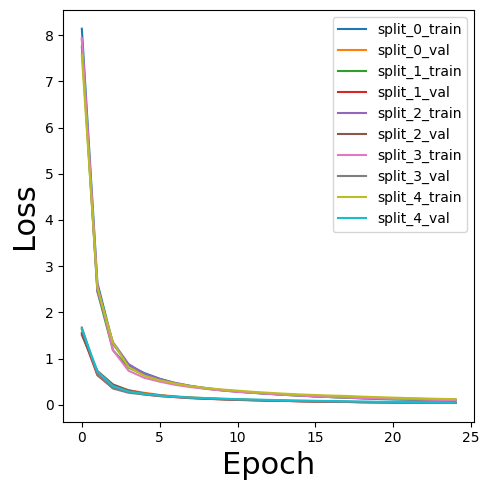

In [8]:
import matplotlib.pyplot as plt

def plot_history(train_losses, val_losses):
    # fig, ax = plt.subplots(1, 5, figsize=(12, 3), tight_layout=True)
    # for split in range(len(train_losses)):
    #     ax[split].plot(train_losses[split], label=f"split_{split}_train")
    #     ax[split].plot(val_losses[split], label=f"split_{split}_val")
    #     ax[split].set_xlabel("Epoch", fontsize=14)
    #     ax[split].set_ylabel("Loss", fontsize=14)
    #     ax[split].legend()
    # plt.show()
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    for split in range(len(train_losses)):
        ax.plot(train_losses[split], label=f"split_{split}_train")
        ax.plot(val_losses[split], label=f"split_{split}_val")
        ax.set_xlabel("Epoch", fontsize=22)
        ax.set_ylabel("Loss", fontsize=22)
    ax.legend()
    plt.show()

plot_history(train_losses, val_losses)

In [1]:
# calculate RMSE for the reconstruction
from sklearn.metrics import mean_squared_error

def rmse(pred, target):
    return np.sqrt(mean_squared_error(pred, target))

In [10]:
# using it for the embedding of the test data
model = train.best_model

model.eval()
test_losses, test_embeddings = [], []
test_loader = NeighborLoader(
    training_data,
    input_nodes=training_data.test_mask[:, 4],
    num_neighbors=[5,4],
)

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        _, _, embedding = model(batch)
        test_embeddings.append(embedding.cpu().numpy())

In [14]:
test_embeddings = np.concatenate(test_embeddings, axis=0)

In [16]:
test_embeddings.shape

(6036, 32)

In [19]:
from sklearn.manifold import TSNE
from umap import UMAP

def plot_embedding(embedding, labels, title=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    plt.show()

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
/tmp/ipykernel_724218/2431578229.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=10)


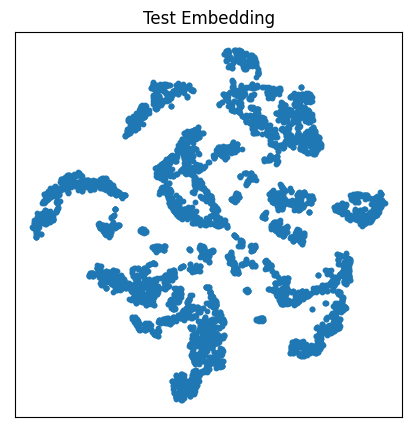

In [20]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1)
test_tsne = tsne.fit_transform(test_embeddings)
plot_embedding(test_tsne, labels=None, title="Test Embedding")

/tmp/ipykernel_724218/2431578229.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=10)


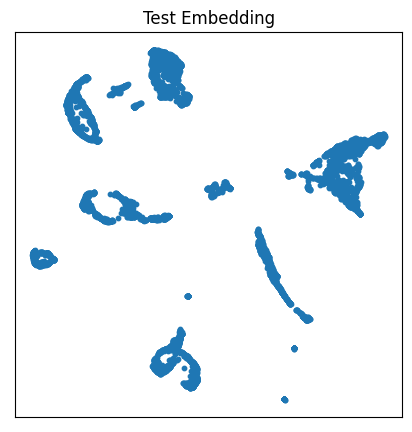

In [21]:
umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
test_umap = umap.fit_transform(test_embeddings)
plot_embedding(test_umap, labels=None, title="Test Embedding")

In [29]:
from torch.nn.parallel import DistributedDataParallel as DDP
from torch_geometric.loader import NeighborLoader

def ddp_run(rank: int, world_size: int, dataset: None, model: nn.Module):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = '10086'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    data = dataset
    train_index = data.train_mask.nonzero().view(-1)
    train_index = train_index.split(train_index.size(0) // world_size)[rank]

    train_loader = NeighborLoader(
        data,
        input_nodes=train_index,
        num_neighbors=[25, 10],
        batch_size=128,
        num_workers=4,
        shuffle=True,
    )

    if rank == 0:
        val_index = data.val_mask.nonzero().view(-1)
        val_loader = NeighborLoader(
            data, 
            input_nodes=val_index,
            batch_size=128,
            num_workers=4,
            shuffle=False,
        )
    torch.manual_seed(0)
    model = model.to(rank)
    model = DDP(model, device_ids=[rank])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(1, 11):
        model.train()
        for batch in train_loader:
            batch = batch.to(rank)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)[:batch.batch_size]
            loss = F.cross_entropy(out, batch.x[:batch.batch_size])
            loss.backward()
            optimizer.step()

tensor([[5529, 3801,  703,  ..., 1152, 4459, 7859],
        [6484, 7814, 1179,  ..., 2422, 1936, 1823]])